In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt
import re

from datetime import timedelta

In [2]:
data = pd.read_csv('matala2_cosmetics_2019-Nov.csv').copy()

c:\Users\yaron\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


***
# Q1

In [3]:
data['event_time'] = pd.to_datetime(data.event_time)   # convert col to full time format
data = data.sort_values(['user_id', 'event_time'])   # sort df by acsending
data['duration_to_next_event'] = abs(data['event_time'].diff(periods = -1).dt.total_seconds()) # calculate seconds difference between current and prev visit
data['duration_to_next_event'] = data['duration_to_next_event'].fillna(0)

In [4]:
data.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event
437209,2019-11-04 15:28:57+00:00,view,5240,1487580009202712597,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1276032.0


***
# Q2

In [5]:
# calc days diff between visits
data = data.sort_values(['user_id', 'event_time'])
data['days_diff'] = data.groupby('user_id')['event_time'].diff().dt.days
col = data['days_diff'] > 5

data['funnel_number'] = col.groupby(data['user_id']).cumsum() + 1
data['funnel_number'] = data['funnel_number'].fillna(0)

data = data.drop(columns=['days_diff'])

In [6]:
data['funnel_number'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [7]:
data.user_session.unique()

array(['d0484d94-7ac1-44e8-a310-2360da11ad9d',
       'b16644a2-44db-4650-8156-f6f03782d432',
       '6873a205-d9f5-4d51-b3eb-b4bfddfe907c', ...,
       'a06e9a89-55ff-4c3a-abd6-aa4fdf808058',
       '878af093-7570-48ae-966c-d50ce61e390c',
       'e9fa2c3e-8c9e-448c-880a-21ca57c18b3b'], dtype=object)

***
# Q3

In [8]:
data = data.sort_values(['user_id', 'funnel_number', 'event_time'])
data['temp'] = data.groupby(['user_id', 'funnel_number', 'user_session'])['user_session'].shift().ne(0).astype(int)

In [9]:
data['index_in_funnel'] = data.groupby(['user_id' , 'funnel_number'])['temp'].cumsum()
data = data.drop(columns=['temp'])

***
# Q4

In [10]:
fix = re.compile(r'\d+\.?\d*')
data['price'] = data['price'].astype(str)
data['price'] = data['price'].apply(lambda x: float(fix.findall(x)[0]))
#print(data['price'].dtype)

***
# Q5

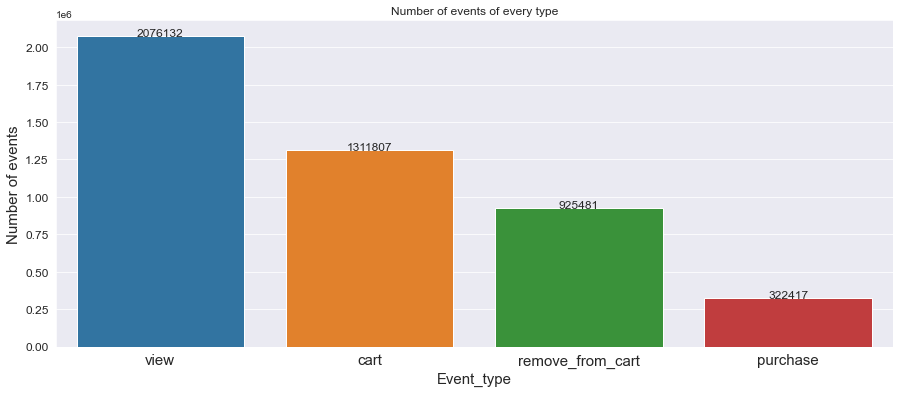

In [11]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 6))

ax = sns.countplot(data = data, x = 'event_type')
plt.title('Number of events of every type')
plt.xlabel('Event_type', fontsize = 15)
plt.ylabel('Number of events', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width()/2, p.get_height() + 0.5), ha = 'center', fontsize = 12)
    
plt.show()

***
# Q6

In [12]:
# a, b, c, d
data_abcd = data[['user_id','user_session','funnel_number','index_in_funnel']].copy()

In [13]:
# e, f
data_abcd['total_events'] = data.groupby('user_session')[['event_type']].transform('count')
data_abcd['visit_duration'] = data.groupby(['funnel_number', 'user_session'])[["duration_to_next_event"]].transform('sum')

In [14]:
data.event_type.unique()

array(['view', 'cart', 'remove_from_cart', 'purchase'], dtype=object)

In [15]:
# g, h, i
data_ghi = data.groupby(['user_id', 'user_session']).apply(
    lambda x: pd.Series({
        'list_of_viewed': list(x.loc[x['event_type'] == 'view', 'product_id']),
        'list_of_added_to_cart': list(x.loc[x['event_type'] == 'cart', 'product_id']),
        'list_of_purchased': list(x.loc[x['event_type'] == 'purchase', 'product_id'])
    })
).reset_index()

In [ ]:
session_data = pd.merge(data_abcd, data_ghi , how = 'left', on = ['user_id', 'user_session'])

In [ ]:
session_data.head()

,user_id,user_session,funnel_number,index_in_funnel,total_events,visit_duration,list_of_viewed,list_of_added_to_cart,list_of_purchased
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,1.0,155497.0,[5240],[],[]
1,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,1,4.0,229972.0,[],"[5614842, 5766379]","[5766379, 5614842]"
2,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,2,4.0,229972.0,[],"[5614842, 5766379]","[5766379, 5614842]"
3,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,3,4.0,229972.0,[],"[5614842, 5766379]","[5766379, 5614842]"
4,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,4,4.0,229972.0,[],"[5614842, 5766379]","[5766379, 5614842]"
